# Preprocessing and analysis of PhIP-seq data to discover Anti-HU 

In this tutorial, you will learn how to analyze phip-seq data with PhagePy. The data used in this tutorial is from the paper [High-resolution epitope mapping of anti-Hu and anti-Yo autoimmunity by programmable phage display](https://academic.oup.com/braincomms/article/2/2/fcaa059/5843781#206277565).

## Loading phagepy 

In [2]:
import numpy as np
import pandas as pd
#from array import array
#from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc

# Preprocessing

## Reading in data
### data structure
Phagepy uses the [anndata](https://anndata.readthedocs.io/en/latest/) data structure to store metadata, sequencing counts, and gene annotation information in one object. Reading this documentation will be very helpful to understanding how to manipulate adata objects for this analysis! 
### how to load the data
Phagepy has a command, `create_anndata()` to load metadata and sequencing counts into an anndata object. `create_anndata()` has 3 parameters:
1. `counts_file`: a csv file with counts for each sample in rpk. 
2. `metadata_file`: a metadata file with annotations for each sample
    1. **note**: the sample ids in the first column of the metadata file **must** match the sample ids in the counts file
3.`transpose`(default=True): a boolean parameter.
    1. if your input counts file is (peptides)x(samples), then `transpose` should be set to True. Note: this is how data downloaded from PhageDB is formatted. 
    2. if your input counts file is (samples)x(peptides), then `transpose` should be set to True.

In [3]:
counts='antihu_counts.csv'
meta='antihu_metadata.csv'
adata=pp.create_anndata(counts, meta)

### How to manipulate the adata object

The `adata` object is of shape (samples)x(peptides):

In [4]:
adata

AnnData object with n_obs × n_vars = 10 × 731724
    obs: 'IProunds', 'sick', 'healthy', 'study', 'fluid', 'experimenter', 'group', 'ng_input', 'notes'

Counts are stored in `adata.X`:

In [5]:
adata.X[:4,:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.23583181,
        0.        , 0.        , 0.        , 0.        , 0.78610605],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5092825 , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

Metadata is stored in `adata.obs`

In [6]:
adata.obs

,IProunds,sick,healthy,study,fluid,experimenter,group,ng_input,notes
CMB-NID-624_S4_L001_R1_001,2,no,NaN,NID,CSF,CMB,HU,NaN,NaN
NID-624_S8_L001_R1_001,2,no,NaN,NID,CSF,CMB,HU,NaN,NaN
NID_624_CSF_2_rnd3_S34_L005_R1_001,3,no,NaN,NID,CSF,CMB,HU,NaN,NaN
NID_624_CSF_rnd3_S33_L005_R1_001,3,no,NaN,NID,CSF,CMB,HU,NaN,NaN
01112017-1-AG_S1_L001_R1_001,2,no,NaN,NID,NaN,CMB,AG,NaN,NaN
09052017-13-AG2rounds_S13_L001_R1_001,2,no,NaN,NID,NaN,CMB,AG,NaN,NaN
080517-GFAP_S7_L001_R1_001,2,no,NaN,NID,NaN,CMB,GFAP,NaN,NaN
080617-GFAP_S4_L001_R1_001,2,no,NaN,NID,NaN,CMB,GFAP,NaN,NaN
CMB-GFAP_S10_L001_R1_001,2,no,NaN,NID,NaN,CMB,GFAP,NaN,NaN
030817-A6-TUB_S6_L001_R1_001,2,no,NaN,NID,NaN,CMB,TUB,NaN,NaN


you can take subsets of the data by filtering on `adata.obs` values:

In [7]:
adata[adata.obs.group=='AG']

View of AnnData object with n_obs × n_vars = 2 × 731724
    obs: 'IProunds', 'sick', 'healthy', 'study', 'fluid', 'experimenter', 'group', 'ng_input', 'notes'

## Pseudocount
phagepy uses pseudocounted rpk values for analysis, to avoid pesky zeros :)

In [8]:
adata.X=adata.X+1

## Define the control group

In phagepy, data are normalized to a **control group**, which is usually a group of Mock IP samples. This group of samples is used to define the background noise of the experiment. 

To define the control group, run the command `define_ctrl_set()`, which has the following parameters 
- `obs_key`: the column of the metadata which defines the categories of samples
- `obs_value`: the category of samples from the above column we wish to define the control group
- (optional)`key_ids`(default='control_ids'): provides the key to access the control ids in the adata object. 

So, for example, in this dataset `obs_key='group'` and `obs_value='AG'`

`define_ctrl_set()` returns an adata object with `adata.uns['control_ids']`(or other `key_ids` value if using non-default) holding the sample ids of control samples.

In [9]:
adata=pp.define_ctrl_set(adata, obs_key='group', obs_value='AG')
adata

AnnData object with n_obs × n_vars = 10 × 731724
    obs: 'IProunds', 'sick', 'healthy', 'study', 'fluid', 'experimenter', 'group', 'ng_input', 'notes'
    uns: 'control_ids'

## Filter out control group
After defining the control group, we can then filter it out of our main adata object. Even though we filter it out of the main adata object, **it is still accessible!**

To filter out the control group, use the command `filter_out_ctrl_set`, which has the following **optional** parameters: 
- `key_ids`(default='control_ids'): only set this parameter if you changed the `key_ids` param in `define_ctrl_set()`
- `key_X`(default='X_control'): provides the key to access the count data of the control samples

In [10]:
adata=pp.filter_out_ctrl_set(adata)
adata

View of AnnData object with n_obs × n_vars = 8 × 731724
    obs: 'IProunds', 'sick', 'healthy', 'study', 'fluid', 'experimenter', 'group', 'ng_input', 'notes'
    uns: 'control_ids'
    varm: 'X_control'

## Calculate enrichment over controls 

To normalize our samples against the background, we can calculate enrichment over the AG-bead background. 

To do this, we run `peptide_fold_change` which calculates fold-change enrichment over the expected rpk for each peptide in the control group. Expected rpk can be defined as the median or average of the peptide expression in the control group, and users can choose which metric to define the expected rpk using the `metric` parameter (default='median')

In [11]:
adata.layers['FC_over_AG']=pd.DataFrame(data=pp.peptide_fold_change(adata),
                                   index=adata.obs.index,
                                   columns=adata.var.index)

## scaling....eh

## Filtering out low-count peptides 

This can be a personal call, but it is good to at least filter out peptides with practically zero counts. 

**Why wouldn't I use a big rpk filter?**
    As phip-seq is semi-quantitative, it is very possible that real autoantibody binding has very little expression in the phip-seq genomic read-out. There are examples of low-rpk peptides being externally validated, so if you are worried about missing anything I would be conservative with the rpk filter.

**Why would I use a a big rpk filter?**
    A lot of experimental noise is found in the low rpk hits, so filtering it out can help eliminate noise. Additionally, it is an easy way to reduce our peptide space which makes further computation easier. 
    

In [15]:
rpk_filter=25

In [16]:
keeps=adata.var.index[adata.layers['FC_over_AG'].sum(axis=0)>rpk_filter]
adata=adata[:,keeps]
adata

View of AnnData object with n_obs × n_vars = 8 × 2429
    obs: 'IProunds', 'sick', 'healthy', 'study', 'fluid', 'experimenter', 'group', 'ng_input', 'notes'
    uns: 'control_ids'
    varm: 'X_control'
    layers: 'FC_over_AG'

## testing plotting 

In [59]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib as mpl

def PCA_samples_2D(adata, layer_='FC_over_AG', raw=False):
    """
    runs PCA for visualization on samples
    
    input:  - adata: data object
            - layer_: the layer of rpk counts to use to perform dim reduction
                       - default='FC_over_AG', the fold-change transformed RPK counts
            - raw: if True, then use raw RPK counts to perform dim reduction
                       - default=False
    output: - principalDF: dataframe w/ shape samplesx2, with coordinates of each     sample in principal component space
    """
    pca = PCA(n_components=2)
    if raw is True:
        principalComponents = pca.fit_transform(adata.X)
    else:
        principalComponents = pca.fit_transform(adata.layers[layer_])

    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index = adata.obs.index)
    return principalDf

def plot_PCA_samples_2D(adata, layer_='FC_over_AG', raw=False, obs_key=None, print_title=None,
                       obs_colors=None, save=False, save_title=None, save_dir=None, 
                       zoom=False, zoom_xlim=None, zoom_ylim=None):
    """
    Runs dimensionality reduction with PCA and visualizes samples in 2D PCA space.
    
    Input:  - adata: data object
            - layer_: the layer of rpk counts to use to perform dim reduction
                       - default='FC_over_AG', the fold-change transformed RPK counts
            - raw: if True, then use raw RPK counts to perform dim reduction
                       - default=False
            - (optional) obs_key: if you want to color samples by a category, 
                                  obs_key is the category variable in the adata object
                       - eg, obs_key='disease' w/ adata.obs['disease']=['healthy','disease']
            - (optional) obs_colors: if you want to color samples by a category, 
                                     this provides the colors. needs to be a list or 
                                     dict of length equal to the num of category values
                                     in the obs_key command
                       - eg, obs_key='disease', obs_colors=['blue','red']
            - save: boolean directing matplotlib to save the plot, default=False
            - (optional) save_title: title for plot
            - (optional) save_dir: path where plot is saved
    Output: 2D plot of PCA, which is optionally saved
    
    """
    ## run the PCA ##
    principalDf=PCA_samples_2D(adata, layer_, raw)
    
    ## plot the PCA ## 
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    
    # if grouping
    if obs_key:
        targets = adata.obs[obs_key].unique()
        
        #make color dict if not passed
        if not obs_colors: 
            n=len(targets)
            colors=mpl.cm.Set1.colors[:n] # Set1 is default palette
        else:
            colors=obs_colors
            
        for target, color in zip(targets,colors):
            indicesToKeep = adata.obs.index[adata.obs[obs_key] == target]
            ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                       principalDf.loc[indicesToKeep, 'principal component 2'],
                       color = color,
                       s = 50)
        
        ax.legend(targets)

    #if not grouping
    else:
        ax.scatter(principalDf.loc[:,'principal component 1'],
                   principalDf.loc[:,'principal component 2'], 
                  color = 'r',
                  s= 50)
    
    # if zoom
    if zoom:
        ax.set_xlim(zoom_xlim)
        ax.set_ylim(zoom_ylim)
    
    if print_title:
        ax.set_title(print_title,fontsize=25)
    
    if save:
        plt.savefig(save_dir+save_title)
    
    plt.show()

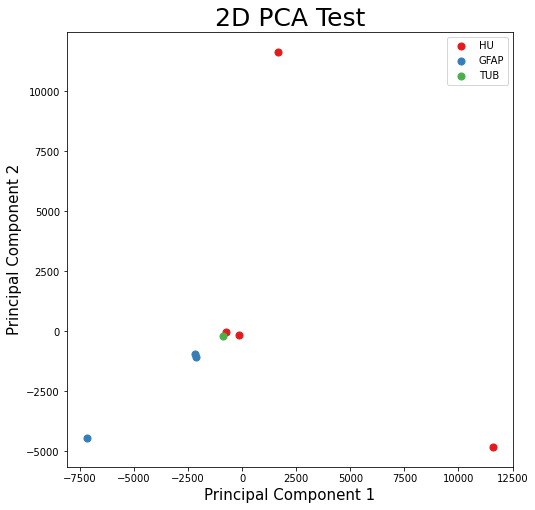

In [62]:
plot_PCA_samples_2D(adata, obs_key='group', print_title='2D PCA Test',save=True, 
                    save_dir='/Users/haleighmiller/phagepy_dev/tutorials/',
                   save_title='testpca.png')

In [64]:
type(pd.DataFrame(adata.obs))

pandas.core.frame.DataFrame

In [31]:
adata.obs

,IProunds,sick,healthy,study,fluid,experimenter,group,ng_input,notes
CMB-NID-624_S4_L001_R1_001,2,no,NaN,NID,CSF,CMB,HU,NaN,NaN
NID-624_S8_L001_R1_001,2,no,NaN,NID,CSF,CMB,HU,NaN,NaN
NID_624_CSF_2_rnd3_S34_L005_R1_001,3,no,NaN,NID,CSF,CMB,HU,NaN,NaN
NID_624_CSF_rnd3_S33_L005_R1_001,3,no,NaN,NID,CSF,CMB,HU,NaN,NaN
080517-GFAP_S7_L001_R1_001,2,no,NaN,NID,NaN,CMB,GFAP,NaN,NaN
080617-GFAP_S4_L001_R1_001,2,no,NaN,NID,NaN,CMB,GFAP,NaN,NaN
CMB-GFAP_S10_L001_R1_001,2,no,NaN,NID,NaN,CMB,GFAP,NaN,NaN
030817-A6-TUB_S6_L001_R1_001,2,no,NaN,NID,NaN,CMB,TUB,NaN,NaN
